In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    classification_report, confusion_matrix, roc_curve, auc
)
import matplotlib.pyplot as plt
import seaborn as sns
import joblib


In [2]:
true_news = pd.read_csv("C:/Users/paulm/Downloads/archive (2)/True.csv")
fake_news = pd.read_csv("C:/Users/paulm/Downloads/archive (2)/Fake.csv")

# Add labels
true_news["label"] = 1
fake_news["label"] = 0

# Combine and shuffle
data = pd.concat([true_news, fake_news], axis=0).sample(frac=1).reset_index(drop=True)

X = data["text"]
y = data["label"]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# TF-IDF vectorization
vectorizer = TfidfVectorizer(stop_words='english', max_df=0.7)
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

**Naive Bayes**

In [4]:
nb_model = MultinomialNB()
nb_model.fit(X_train_tfidf, y_train)
y_pred_nb = nb_model.predict(X_test_tfidf)
y_prob_nb = nb_model.predict_proba(X_test_tfidf)[:,1]

print("Naive Bayes Results:")
print("Accuracy:", accuracy_score(y_test, y_pred_nb))
print("Precision:", precision_score(y_test, y_pred_nb))
print("Recall:", recall_score(y_test, y_pred_nb))
print("F1 Score:", f1_score(y_test, y_pred_nb))
print("\nClassification Report:\n", classification_report(y_test, y_pred_nb))

Naive Bayes Results:
Accuracy: 0.9364142538975501
Precision: 0.9361601884570082
Recall: 0.9298081422554983
F1 Score: 0.9329733536800094

Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.94      0.94      4706
           1       0.94      0.93      0.93      4274

    accuracy                           0.94      8980
   macro avg       0.94      0.94      0.94      8980
weighted avg       0.94      0.94      0.94      8980



**Naive Bayes fed into Decision tree**

In [6]:
nb_train_probs = nb_model.predict_proba(X_train_tfidf)
nb_test_probs = nb_model.predict_proba(X_test_tfidf)

hybrid_dt = DecisionTreeClassifier(max_depth=5, random_state=42)  # shallow tree for hybrid
hybrid_dt.fit(nb_train_probs, y_train)

y_pred_hybrid = hybrid_dt.predict(nb_test_probs)
y_prob_hybrid = hybrid_dt.predict_proba(nb_test_probs)[:,1]

print("\nHybrid Model Results (NB → DT):")
print("Accuracy:", accuracy_score(y_test, y_pred_hybrid))
print("Precision:", precision_score(y_test, y_pred_hybrid))
print("Recall:", recall_score(y_test, y_pred_hybrid))
print("F1 Score:", f1_score(y_test, y_pred_hybrid))
print("\nClassification Report:\n", classification_report(y_test, y_pred_hybrid))



Hybrid Model Results (NB → DT):
Accuracy: 0.9375278396436526
Precision: 0.9282583621683967
Recall: 0.9415067852129153
F1 Score: 0.93483563712394

Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.93      0.94      4706
           1       0.93      0.94      0.93      4274

    accuracy                           0.94      8980
   macro avg       0.94      0.94      0.94      8980
weighted avg       0.94      0.94      0.94      8980



**Confusion Matrices**

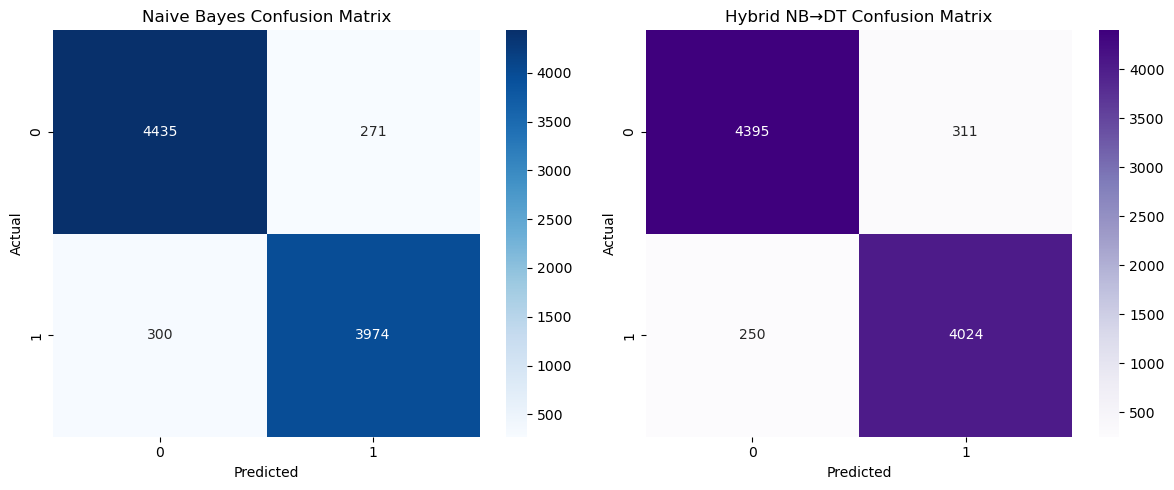

In [15]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Naive Bayes
cm_nb = confusion_matrix(y_test, y_pred_nb)
sns.heatmap(cm_nb, annot=True, fmt="d", cmap="Blues", ax=axes[0])
axes[0].set_title("Naive Bayes Confusion Matrix")
axes[0].set_xlabel("Predicted")
axes[0].set_ylabel("Actual")

# Hybrid NB→DT
cm_hybrid = confusion_matrix(y_test, y_pred_hybrid)
sns.heatmap(cm_hybrid, annot=True, fmt="d", cmap="Purples", ax=axes[1])  # axes[1], not axes[2]
axes[1].set_title("Hybrid NB→DT Confusion Matrix")
axes[1].set_xlabel("Predicted")
axes[1].set_ylabel("Actual")

plt.tight_layout()
plt.show()


**ROC Curves**

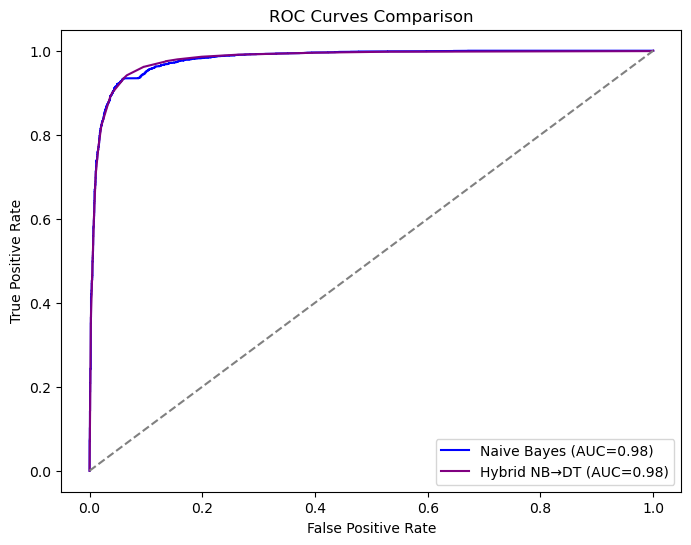

In [20]:
from sklearn.metrics import roc_curve, auc

# Naive Bayes ROC
fpr_nb, tpr_nb, _ = roc_curve(y_test, y_prob_nb)
roc_auc_nb = auc(fpr_nb, tpr_nb)

# Hybrid NB→DT ROC
fpr_hybrid, tpr_hybrid, _ = roc_curve(y_test, y_prob_hybrid)
roc_auc_hybrid = auc(fpr_hybrid, tpr_hybrid)

# Plot combined ROC
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))
plt.plot(fpr_nb, tpr_nb, label=f"Naive Bayes (AUC={roc_auc_nb:.2f})", color="blue")
plt.plot(fpr_hybrid, tpr_hybrid, label=f"Hybrid NB→DT (AUC={roc_auc_hybrid:.2f})", color="purple")
plt.plot([0,1],[0,1],'--',color='grey')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves Comparison")
plt.legend()
plt.show()


In [ ]:
import joblib
joblib.dump(nb_model, "naive_bayes.pkl")


In [ ]:
joblib.dump(hybrid_dt, "hybrid_d.pkl")

In [ ]:
joblib.dump(vectorizer, "tfidf_vectorizer.pkl")